# Extracting the maximum likelihood model from fit results

This is the first in a new series of examples I'm putting together to demonstrate how to do some more advanced things with the code. These are more stand-alone than the basic examples, and will be added to as I receive requests for more information from users. It's probably best to use these as a reference guide rather than working through them in order, however the functions I introduce here may also be helpful when doing other things with the code.

It's probably worth noting that the basic examples are currently written in Python 2, whereas I've made the change to Python 3 for these advanced topics.

**Please read the important caveat at the bottom before using maximum likelihood quantities calculated using the method given below.**

## Setting up

Let's begin by running a quick new fit to the same object from GOODSS that we used in Example 4.

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ Load CANDELS GOODS South photometry from the Guo et al. (2013) catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str").tolist()

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)

# Now make a fit instructions dictionary, the details aren't important for this example.

dblplaw = {}                        
dblplaw["tau"] = (0., 15.)
            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0.1, 2.5)

dust = {}                           
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)

nebular = {}
nebular["logU"] = -3.

fit_info = {}
fit_info["redshift"] = (0., 10.)
fit_info["dblplaw"] = dblplaw 
fit_info["dust"] = dust
fit_info["nebular"] = nebular


Bagpipes: fitting object 17433


Completed in 258.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 67.689    222.310    613.028
dblplaw:beta                   0.043      0.793     25.094
dblplaw:massformed            11.056     11.184     11.248
dblplaw:metallicity            0.706      1.144      1.659
dblplaw:tau                    4.443      4.857      5.129
dust:Av                        0.257      0.419      0.587
redshift                       1.008      1.049      1.093




/Users/adam/anaconda3/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:261: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


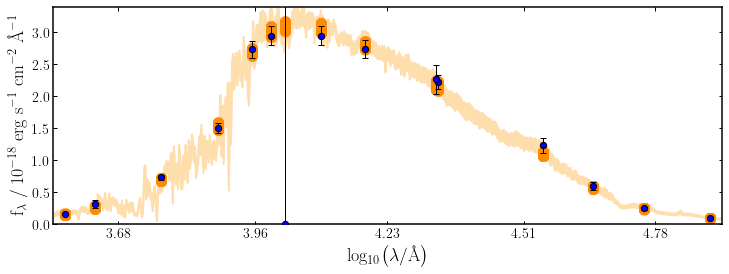

In [2]:
fit = pipes.fit(galaxy, fit_info, run="advanced_1")

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)

## Finding the maximum likelihood model parameters

The code stores basic output quantities such as the log-likelihood values for each point in the posterior distribution in the fit.results dictionary.

For example:

In [3]:
print(type(fit.results["lnlike"]), len(fit.results["lnlike"]))

<class 'numpy.ndarray'> 2208


To find out which point in the posterior has the highest likelihood we can use numpy.argmax:

In [4]:
max_like_index = np.argmax(fit.results["lnlike"])
print(max_like_index)

2192


The parameter values for each point in the posterior are also stored in a 2D array within fit.results, called samples2d. We can extract the maximum likelihood model parameters from samples2d using the index we just extracted from the lnlike array:

In [5]:
print(fit.results["samples2d"][max_like_index, :])

[5.53073200e+02 8.61505106e-01 1.11921380e+01 9.92588333e-01
 4.96958872e+00 4.69545284e-01 1.04368319e+00]


As a side note, the ordering of these parameters can be found under fit.fitted_model.params. However we don't actually need to know this to generate the maximum likelihood model, as you'll see below.

## Generating the maximum likelihood model

fit.fitted_model also contains a handy function for generating a model_components dictionary directly from this list of parameter values. Obviously this is specific to the fit from which the maximum likelihood parameter values were extracted. 

We can use fit.fitted_model.\_update_model_components to generate a model_components dictionary for the maximum likelihood model as follows:

In [6]:
fit.fitted_model._update_model_components(fit.results["samples2d"][max_like_index, :])

max_like_model_components = fit.fitted_model.model_components

print(max_like_model_components)

{'redshift': 1.0436831932741044, 'dblplaw': {'tau': 4.969588723259325, 'alpha': 553.0732001299658, 'beta': 0.8615051062452758, 'alpha_prior': 'log_10', 'beta_prior': 'log_10', 'massformed': 11.192137972656683, 'metallicity': 0.9925883332110328}, 'dust': {'type': 'Calzetti', 'Av': 0.4695452843419301}, 'nebular': {'logU': -3.0}}


And finally we can generate the maximum likelihood model (with the same observables and/or different ones) by feeding this model into a new model_galaxy object:

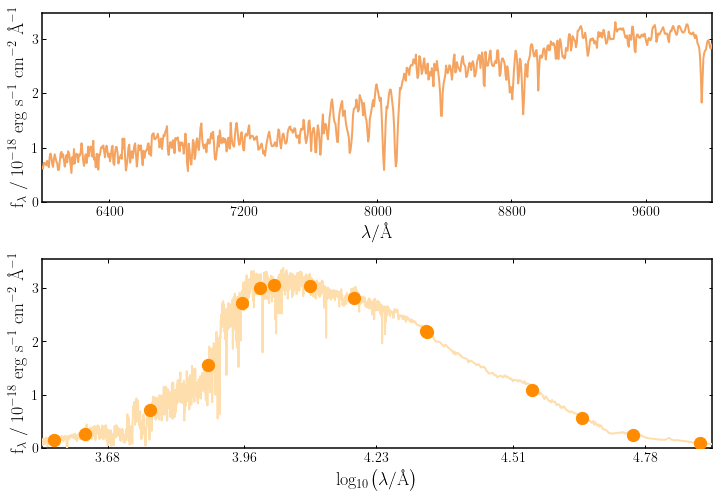

In [7]:
max_like_model_galaxy = pipes.model_galaxy(max_like_model_components,
                                           filt_list=goodss_filt_list,
                                           spec_wavs=np.arange(6000., 10000., 5.))

fig = max_like_model_galaxy.plot()

You can then access the predicted max likelihood observables in the same way as you would for any other model galaxy object:

In [8]:
print(max_like_model_galaxy.photometry)

[1.54589782e-19 2.61492419e-19 7.11255617e-19 1.56246153e-18
 2.72541826e-18 2.99842755e-18 3.06519729e-18 3.04500772e-18
 2.80726429e-18 2.17050431e-18 2.18820561e-18 1.09809163e-18
 5.62897066e-19 2.41594725e-19 9.31324160e-20]


In [9]:
print(max_like_model_galaxy.sfh.stellar_mass)

10.93314492326269


# A very important caveat!

It's important to remember that the MultiNest algorithm Bagpipes uses is optimised to achieve a good approximation of the evidence and shape of the posterior with the most efficient possible sampling of parameter space. Unlike more traditional algorithms used for this kind of problem, its primary aim is **NOT** to search parameter space for the maximum of the posterior/likelihood distribution.

The method described above picks out the point in the MultiNest posterior with the highest likelihood out of the samples that were generated as it explored parameter space. This is likely to be close to the maximum likelihood, but it's almost guaranteed that other points in parameter space, which weren't directly sampled by MultiNest, will have higher likelihood. You also won't get exactly the same max. likelihood parameters if you run the algorithm again.

You can get MultiNest to perform a finer sampling of parameter space by increasing the number of live points (n_live) to the highest possible value, e.g. 1000-2500 live points (though the more you use the longer the fit will take). This will increase the reliability of the maximum likelihood values you obtain.
